In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Rectangle
# Local imports

from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import matplotlib

from fields_propagation.functions import cpx_corr
from fields_propagation.fields import laguerre_gauss, hermite_gauss, speckle_gauss
from fields_propagation.fourier_filter import lowpass_filter, fourier_filter
from holograms.dmd_holograms import parallel_lee,  orthogonal_lee, holo_SP, holo_Haskell
from holograms.generate_LUT import generate_lut

from plotting.plot_funs import colorize
from plotting.specialized_functions import plot_holoWzoom, plot_four, plot_fieldWzoom

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title
matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica') 

plt.rcParams.update({"figure.facecolor" : "white"})

## 1. Field definition (LG as an example)

In [71]:
nx = 780 ; ny = 780 # Resolution as multiple of 3 and 4 for superpiel methods
X,Y = np.meshgrid(np.arange(nx)-nx/2,np.arange(ny)-ny/2)

Nt = 55 # Total order of LG beam
ell = -8 # topologicla charge
hlg_sc= 2*1.1 * np.sqrt(Nt+1)/nx # Size of LG beam scales as Nt^(1/2)
field = laguerre_gauss(Nt, ell, hlg_sc*X, hlg_sc*Y)
field /= np.max(np.abs(field)) # set maximum amplitude value to one

(-0.5, 779.5, 779.5, -0.5)

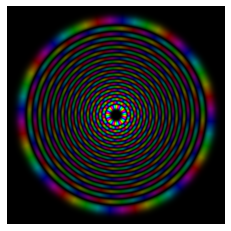

In [72]:
plt.imshow(colorize(field))
plt.gca().axis('off')

## 2. Choosing the aperture size

In [75]:
SA_filter = 1/18
lp_field, ft_field = lowpass_filter(field, SA_filter)

Verify that the aperture is the right size by looking at the Fourier amplitude and the filtered field. Ideally, the filtered field should be equal to the target.

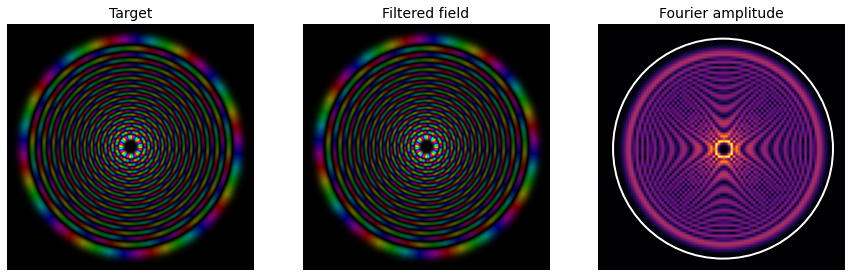

In [76]:
titles =['Target', 'Filtered field', 'Fourier amplitude']
fig, axs = plt.subplots(1,3, figsize=(15,5))
axs[0].imshow(colorize(field))
axs[1].imshow(colorize(lp_field))
plot_four(ft_field, ax=axs[2], log=False, zoom=8, ap_rad=SA_filter, ap_loc=[0,0])
for i, ax in enumerate(axs):
    ax.set_title(titles[i])
    ax.axis('off')

## 3. Shaping with Lee holograms

First we define the hologram parameters

In [82]:
px = 3
nuvec = np.array((1/px,1/px**2)) 
lee_type = 'orthogonal'

Compute the hologram

In [83]:
if lee_type=='orthogonal':
    holo = orthogonal_lee(field, nuvec=nuvec)
elif lee_type=='parallel':
    holo = parallel_lee(field, nuvec=nuvec)
else:
    raise ValueError('Invalid option')

Compute the shaped field

In [89]:
shaped_f, ft_holo = fourier_filter(holo, nuvec, SA_filter, get_ft=True)

Plot the results to verify the results and check there is no overlap between the diffraction orders

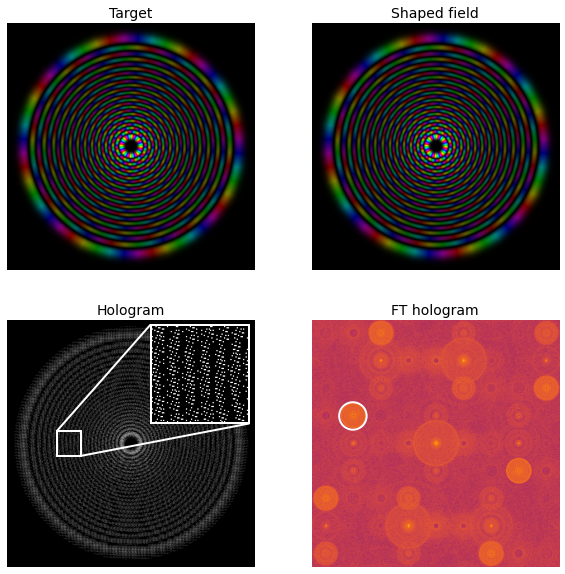

In [90]:
titles =['Target', 'Shaped field', 'Hologram', 'FT hologram']
fig, axs = plt.subplots(2,2, figsize=(10,10))
axs[0,0].imshow(colorize(field))
axs[0,1].imshow(colorize(lp_field))
plot_holoWzoom(holo, ax=axs[1,0], rz=0.05, xyzoom=[0.25,0.5])
plot_four(ft_holo, ax=axs[1,1], log=True, ap_rad=SA_filter, ap_loc=nuvec)
for i, ax in enumerate(axs.ravel()):
    ax.set_title(titles[i])
    ax.axis('off')

## 4. Shaping with super pixel methods

First we define the hologram parameters

In [91]:
px = 3 # take px<5
sp_type = 'sp' #'haskell' 'haskell45'
f_val, px_comb, lut = generate_lut('sp', px)

Compute the hologram

In [94]:
if sp_type=='sp':
    holo = holo_SP(field, lut, px_comb, ds_method='mean')
    nuvec = np.array((1/px,1/px**2)) 
elif sp_type=='haskell':
    holo = holo_Haskell(field, lut, px_comb, ds_method='mean')
    nuvec = np.array((1/px,0)) 
elif sp_type=='haskell45':
    holo = holo_Haskell(field, lut, px_comb, ds_method='mean')
    nuvec = np.array((1/px,1/px)) 
else:
    raise ValueError('Invalid option')

Compute the shaped field

In [95]:
shaped_f, ft_holo = fourier_filter(holo, nuvec, SA_filter, get_ft=True)

Plot the results to verify the results and check there is no overlap between the diffraction orders

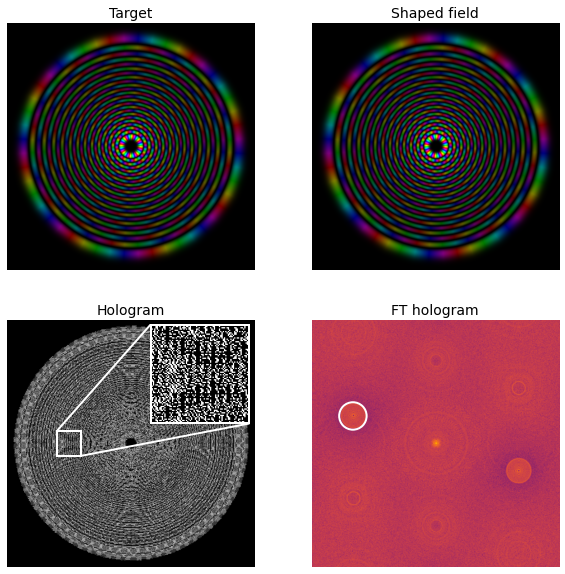

In [96]:
titles =['Target', 'Shaped field', 'Hologram', 'FT hologram']
fig, axs = plt.subplots(2,2, figsize=(10,10))
axs[0,0].imshow(colorize(field))
axs[0,1].imshow(colorize(lp_field))
plot_holoWzoom(holo, ax=axs[1,0], rz=0.05, xyzoom=[0.25,0.5])
plot_four(ft_holo, ax=axs[1,1], log=True, ap_rad=SA_filter, ap_loc=nuvec)
for i, ax in enumerate(axs.ravel()):
    ax.set_title(titles[i])
    ax.axis('off')